In [1]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.ndimage import filters
from skimage import measure
%matplotlib inline

In [2]:
def show_img(img, cmap=None):
    if cmap:
        plt.imshow(img, cmap=cmap)
    else:
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.show()


# Read image

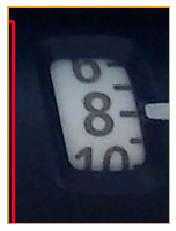

In [3]:
img_origin = cv2.imread("59.17%.jpg")
show_img(img_origin)

In [4]:
img_origin.shape

(189, 141, 3)

# 除去周邊雜訊
1. 轉為灰階
2. 區域二值化(Adaptive Threshold)
3. 區域連通(Connected Component)
4. 切割邊界

## 1. 轉灰階

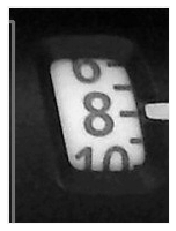

In [7]:
img_gray = cv2.cvtColor(img_origin, cv2.COLOR_BGR2GRAY)
show_img(img_gray, 'gray')

## 2. 區域二值化

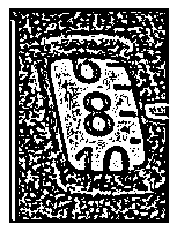

In [8]:
thresh = cv2.adaptiveThreshold(img_gray, maxValue=255, adaptiveMethod=cv2.ADAPTIVE_THRESH_MEAN_C,
                               thresholdType=cv2.THRESH_BINARY, blockSize=7, C=0)
show_img(thresh, 'gray')


參數部分 adaptiveMethod 中可以選擇 ADAPTIVE_THRESH_MEAN_C 或 ADAPTIVE_THRESH_GAUSSIAN_C

使用 ADAPTIVE_THRESH_MEAN_C 時，
會先使用 (blockSize x blockSize) 大小的 Kernel 做均值濾波，邊框則是直接使用邊緣補值出去
接著就是 pixel by pixel 的掃描原圖，若原圖的灰度>濾波出來的灰度，則變為白色，否則變成黑色
而最後的 C ，或稱 delta，則是一個常數用來調整濾波出來的圖的灰度。

若使用 ADAPTIVE_THRESH_GAUSSIAN_C ，
則把 均值濾波 改為 高思濾波

補充說明：
[來源 source code](https://github.com/opencv/opencv/blob/master/modules/imgproc/src/thresh.cpp#L1501)
[Source code 解析](https://www.cnblogs.com/shangd/p/6094547.html)

## 3. 連通法 + 切割邊界

In [9]:
labels = measure.label(thresh, neighbors=8, background=0)
h, w = thresh.shape[:2]
tmp_img = []
for (i, label) in enumerate(np.unique(labels)):  # 連通後會分群組
    if label != 0:
        labelMask = np.zeros(thresh.shape, dtype="uint8")  # 創建一個同等大小的空圖
        labelMask[labels == label] = 255  # 把連通後同一群的pixel 改成 255
        numPixels = cv2.countNonZero(labelMask)  # 統計其數量
        if numPixels / (h * w) > 0.25:  # 若連通後的 pixel > 總像素的 0.25 倍
            tmp_y, tmp_x = np.where(labels == label)  # 取的連通後的上下左右邊界
            tmp_img.append(img_gray[tmp_y.min():tmp_y.max(), tmp_x.min():tmp_x.max()])  # 切割邊界
            show_img(labelMask, 'gray')
            show_img(img_gray[tmp_y.min():tmp_y.max(), tmp_x.min():tmp_x.max()], 'gray')


In [10]:
# 統合成一個 function
def get_plate(image_color):
    image_gray = cv2.cvtColor(image_color, cv2.COLOR_BGR2GRAY)
    thresh = cv2.adaptiveThreshold(image_gray, maxValue=255, adaptiveMethod=cv2.ADAPTIVE_THRESH_MEAN_C,
                                   thresholdType=cv2.THRESH_BINARY, blockSize=7, C=0)
    labels = measure.label(thresh, neighbors=8, background=0)
    tmp_mask = []
    h, w = image_gray.shape[:2]
    for (i, label) in enumerate(np.unique(labels)):
        if label != 0:
            labelMask = np.zeros(thresh.shape, dtype="uint8")
            labelMask[labels == label] = 255
            numPixels = cv2.countNonZero(labelMask)
            if numPixels / (h * w) > 0.25:
                tmp_y, tmp_x = np.where(labels == label)
                tmp_mask.append(image_gray[tmp_y.min():tmp_y.max(), tmp_x.min():tmp_x.max()])
    if len(tmp_mask) == 1:
        return tmp_mask[0]
    else:
        return image_gray


# 圖片縮減

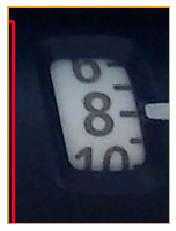

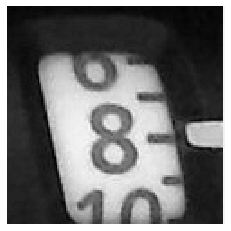

In [11]:
img_gray = get_plate(img_origin)[20:141, 20:189]
show_img(img_origin)
show_img(img_gray, 'gray')

# blackhat
https://www.itread01.com/content/1544450463.html

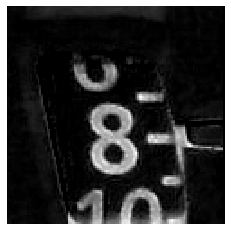

In [30]:
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (10,20))
blackhat = cv2.morphologyEx(img_gray, cv2.MORPH_BLACKHAT, kernel)
show_img(blackhat, 'gray')

# Findcontours¶

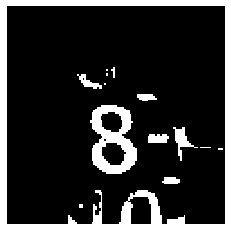

In [33]:
ret,thresh = cv2.threshold(blackhat,65,100,0) 
im,contours,hierarchy = cv2.findContours(thresh,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE) 
show_img(im, 'gray')

In [112]:
#crop_img = im[20:141, 20:189]
#show_img(crop_img, 'gray')
#roi = image[startY:endY, startX:endX]

# get rectangle
https://blog.csdn.net/hjxu2016/article/details/77833984

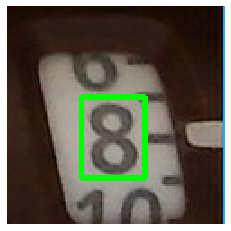

In [49]:
img_origin_copy = img_origin.copy()[20:141, 20:189]
areas = []
for contour in contours:
    x,y,w,h = cv2.boundingRect(contour)
    if w < h:
        areas.append((x, y, w, h, w*h))
max_areas = sorted(areas, key=lambda x:x[4], reverse=True)[:1]
for max_area in max_areas:
    x, y, w, h, _ = max_area
    cv2.rectangle(img_origin_copy, (x-5, y-5), (x+w+4, y+h+2), (0, 255, 0), 2)
    crop = img_origin_copy[y-5:y+h+2,x-5:x+w+4]
    
show_img(img_origin_copy, 'gray')
#cv2.imwrite('1.jpg',crop)